In [ ]:
# This work relies on the the fantatic fastai library v2 (https://github.com/fastai/fastai) 
# Before runing this notebook, please run 'coda env create -f environment_segmentation.yml' in the terminal or Anaconda Prompt
# Then, Activate the new environment

In [1]:
from fastai.vision.all import *
import os
import string

In [2]:
from numpy import asarray

In [3]:
import fastai

In [4]:
from tqdm import tqdm

In [5]:
torch.cuda.set_device('cuda:1')

In [6]:
fastai.__version__

'2.0.16'

In [7]:
torch.cuda.device_count()

6

In [8]:
torch.__version__

'1.6.0'

In [10]:
path = Path('./data')

In [11]:
valid_fnames = [p.name for p in (path/'valid').ls()]

In [12]:
valid_fnames

['343b91fb-2015-43b3-a693-3a6e7320a87a.png',
 '873778aa-999e-44c0-9500-971b6cd8e9ce.png',
 '81d43501-22a4-477e-ad34-9c0046eb351a.png',
 'b77f0c39-9aad-4c50-a59a-a02564a82628.png',
 '50818886-c522-4c73-bfc8-4342b7c7e41a.png',
 '9a6f22df-b900-4875-bc6c-5a5a098b8b87.png',
 '234b2467-fdef-45de-961b-7694ba2e927e.png',
 '43fe7823-e971-4b74-9a49-7a808ad72a7a.png',
 'c5a28cdf-1afc-458a-9d02-e25cf9826bf3.png',
 'aa3fc95d-07c2-41c1-b72a-dfbb21783350.png',
 '6a0f56ac-a2f3-447a-b426-03eee616310e.png']

In [13]:
with open(path/'valid.txt','w') as f:
    for item in valid_fnames:
        f.write("%s\n" % item)

In [15]:
path_im = path/'images'
path_lbl = path/'labels'

In [16]:
# We use 100 samples for demonstration
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

In [17]:
def showValidImageByIndex(i_name):
    _img = PILImage.create(path_im/valid_fnames[i_name])
    _img.show(figsize=(5,5))

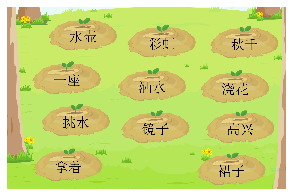

In [18]:
showValidImageByIndex(3)

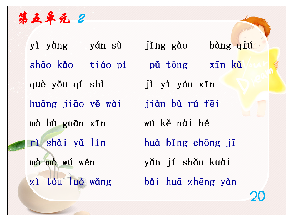

In [19]:
img_fn = fnames[4]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [21]:
def get_msk(o):
    return path/'labels'/f'{o.stem}.png'

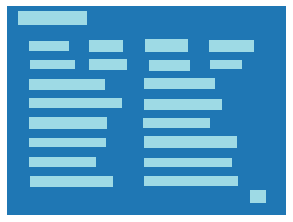

In [22]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [23]:
# For demonstration purposes, there are only two codes of content component in this demo
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['_background_', 'text'], dtype='<U12')

In [24]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    #valid = Path(fname).read().split('\n') 
    with open(fname, 'r') as f:
        valid = f.read().split('\n')
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

# transfer learning between datasets

In [25]:
half=(300,400)

In [26]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [27]:
dls = camvid.dataloaders(path/'images', bs=1)

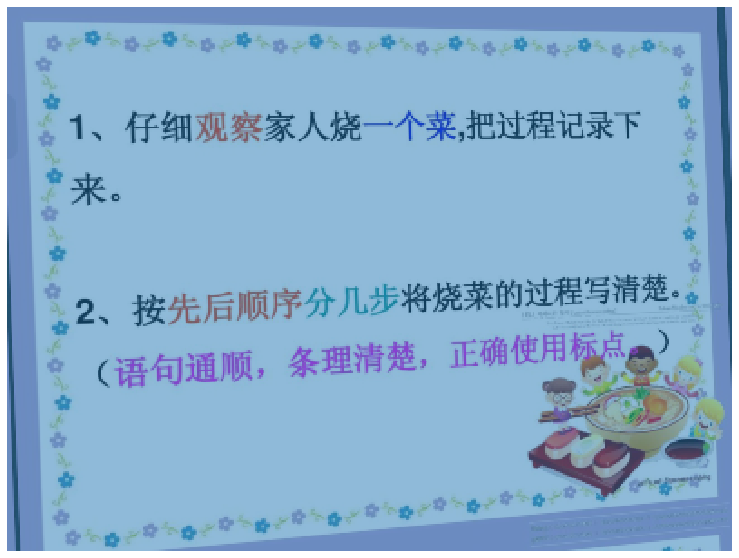

In [28]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [29]:
dls.vocab = codes

In [30]:
name2id = {v:k for k,v in enumerate(codes)}

In [31]:
name2id

{'_background_': 0, 'text': 1}

In [32]:
void_code = name2id['_background_']

In [33]:
def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

# Model

In [34]:
config = unet_config(self_attention=True, act_cls=Mish)

In [35]:
opt = ranger

In [36]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)

In [37]:
learn.summary()

DynamicUnet (Input shape: ['1 x 3 x 300 x 400'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               1 x 64 x 150 x 200   9,408      False     
________________________________________________________________
BatchNorm2d          1 x 64 x 150 x 200   128        True      
________________________________________________________________
ReLU                 1 x 64 x 150 x 200   0          False     
________________________________________________________________
MaxPool2d            1 x 64 x 75 x 100    0          False     
________________________________________________________________
Conv2d               1 x 64 x 75 x 100    36,864     False     
________________________________________________________________
BatchNorm2d          1 x 64 x 75 x 100    128        True      
________________________________________________________________
ReLU                 1 x 64 x 75 x 100    0          False     
_________________________________________________

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=0.004365158267319202)

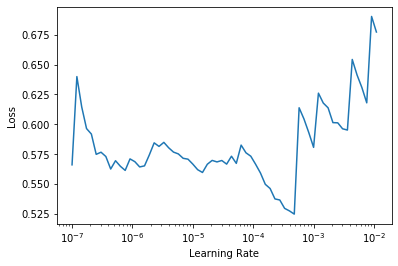

In [38]:
learn.lr_find()

In [39]:
# lr = 5*1e-4
# lr = 1e-7
lr = 1e-3

In [40]:
learn.fit_flat_cos(15, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.255393,0.113136,0.715837,00:09
1,0.222986,0.106070,0.779878,00:09
2,0.184740,0.095814,0.814342,00:09
3,0.177711,0.145703,0.571660,00:09
4,0.153125,0.092115,0.804788,00:09
5,0.140500,0.096861,0.790352,00:09
6,0.160073,0.079020,0.848946,00:09
7,0.140260,0.080723,0.855159,00:09
8,0.111603,0.081236,0.836030,00:09
9,0.118419,0.073334,0.842615,00:09


In [41]:
lr=3e-4
learn.fit_flat_cos(4, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.076383,0.063723,0.873098,00:09
1,0.075373,0.068931,0.904341,00:09
2,0.069744,0.066000,0.901307,00:09
3,0.064500,0.066333,0.912019,00:09


In [42]:
learn.save('text-sgementation-stage-1')

Path('models/text-sgementation-stage-1.pth')

In [43]:
learn.load('text-sgementation-stage-1')

### unfreeze

In [42]:
lrs = slice(lr/400, lr/4)

In [43]:
lr, lrs

(0.0003, slice(7.499999999999999e-07, 7.5e-05, None))

In [44]:
learn.unfreeze()

### train for a bit more

In [45]:
learn.fit_flat_cos(2, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.055960,0.112282,0.856336,00:30
1,0.054511,0.120893,0.847335,00:29


In [46]:
learn.save('text-sgementation-stage-2')

Path('models/text-sgementation-stage-2.pth')

# inference

In [44]:
valid_fnames = [vf for vf in valid_fnames if vf!='']

In [47]:
path_valid_fnames = [path/'images'/valid_name for valid_name in valid_fnames]

In [48]:
dl = learn.dls.test_dl(path_valid_fnames)

In [49]:
preds = learn.get_preds(dl=dl)

In [50]:
def showResult(pred, img_path,alpha=0.5):
    pred = pred.numpy()
    rescaled = (255.0*pred).astype(np.uint8)
    _alpha = int(255*(1-alpha))
    rescaled_red = np.stack([np.ones_like(rescaled)*255,np.zeros_like(rescaled),np.zeros_like(rescaled),rescaled*_alpha],axis=-1)
    maskRed = Image.fromarray(rescaled_red)
    back_src = Image.open(img_path)
    back_src.putalpha(255)
    back_resized = back_src.resize((maskRed.shape[1],maskRed.shape[0]), Image.BILINEAR)
    back_resized.alpha_composite(maskRed)
    return back_resized

In [57]:
#show segmentation result
for i,_p in tqdm(enumerate(path_valid_fnames)):
    im = showResult(preds[0][i].argmax(dim=0),_p,alpha=0.2)
    im.save('./dataset4fastAI/text_sample/export/result/{}.png'.format(_p.stem))

11it [00:01,  8.84it/s]


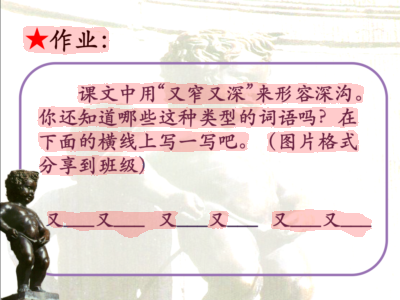

In [52]:
showResult(preds[0][0].argmax(dim=0),path_valid_fnames[0],alpha=0.2)

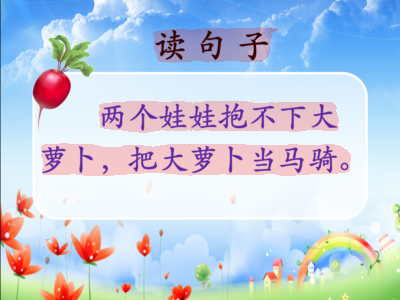

In [53]:
showResult(preds[0][1].argmax(dim=0),path_valid_fnames[1],alpha=0.2)

# export grayscale images with annotations

In [ ]:
# Segmented regions with annotated codes were subsequently merged into artifact data to improve the performance
# of document layout analysis.
# For the text component, merging the segmented regions into grayscale of artfifact images works for text-element layout detection
# For the codes of picture and graph, just use the original images of artifacts.

In [62]:
def exportGrayscale(pred, img_path):
    pred = pred.numpy()
    rescaled = (255.0*pred).astype(np.uint8)
    rescaled_red = np.stack([rescaled,np.zeros_like(rescaled),np.zeros_like(rescaled)],axis=-1)
    img_src = Image.open(img_path)
    img_src = img_src.convert('LA')
    rgbimg = Image.new("RGBA", img_src.size)
    rgbimg.paste(img_src)
    rgbimg_resized = rgbimg.resize((rescaled_red.shape[1],rescaled_red.shape[0]), Image.BILINEAR)
    dst = np.asarray(rgbimg_resized)[...,:3] * 0.5 + rescaled_red*0.5
    return Image.fromarray(dst.astype(np.uint8))

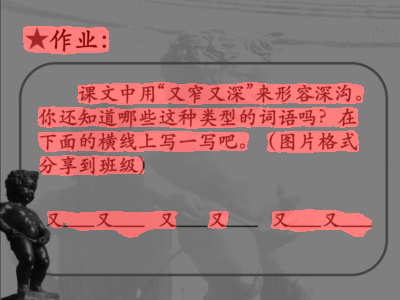

In [63]:
exportGrayscale(preds[0][0].argmax(dim=0),path_valid_fnames[0])

In [67]:
dl_all = learn.dls.test_dl((path/'images').ls())

In [68]:
preds_all = learn.get_preds(dl=dl_all)

In [69]:
#export grayscale images with annotations
for i,_p in tqdm(enumerate((path/'images').ls())):
    im = exportGrayscale(preds_all[0][i].argmax(dim=0),_p)
    im.save('./data/export/grayscale/{}.png'.format(_p.stem))

100it [00:08, 12.06it/s]
